In [1]:
import pandas as pd
import numpy as np

In [11]:
psm_df = pd.read_csv('/Users/eunicekoo/Downloads/psm (1) (1).tsv', sep='\t')
df = pd.read_excel('/Users/eunicekoo/Downloads/Supplemental_Data_2.SAAP_proteins.xlsx', sheet_name='Sheet1')
searched_proteins = ['CAT', 'ACAA2', 'TUBB2A', 'GSTA1', 'EEF1A1', 'TAGLN2', 'GATM', 'HSPA8', 'GAPDH', 'CST1', 'TINAGL1', 'ANXA5', 'FAS', 'AKR1B10', 'TUBA1B', 'LMNA', 'CA1', 'HSPD1', 'ADH4', 'ASS1', 'FUS', 'ALDOA', 'ATP5B', 'TUBA1A', 'ECHS1']

# this cell makes the bp_mtp pairs by pulling the BP & SAAP from the supp data df
protein_bp_mtp = {}

for _, row in df.iterrows():
    leading_proteins = str(row['Genes']).split(';')
    
    for protein in leading_proteins:
        if protein in searched_proteins:
            saap = row['SAAP']
            bp = row['BP']
            
            if protein not in protein_bp_mtp:
                protein_bp_mtp[protein] = []
            
            protein_bp_mtp[protein].append((saap, bp))

In [18]:
results = []

# for each protein
for protein, pairs in protein_bp_mtp.items():

    for saap, bp in pairs:
        protein_matches = psm_df[psm_df['Spectrum'].str.contains(protein, na=False)]

        if not protein_matches.empty:

            saap_matches = protein_matches[
                (protein_matches['Peptide'] == saap) & 
                (protein_matches['Protein'].str.contains('SAAP', na=False)) &
                (protein_matches['Intensity'] > 0)
            ]
    
            bp_matches = protein_matches[
                (protein_matches['Peptide'] == bp) & 
                (~protein_matches['Protein'].str.contains('SAAP', na=False)) &
                (protein_matches['Intensity'] > 0)
            ]

            saap_matches = saap_matches.copy()
            bp_matches = bp_matches.copy()

            saap_matches['Replicate'] = saap_matches['Spectrum'].str.split('.').str[0]
            bp_matches['Replicate'] = bp_matches['Spectrum'].str.split('.').str[0]

            saap_replicate_sums = saap_matches.groupby('Replicate')['Intensity'].sum()
            bp_replicate_sums = bp_matches.groupby('Replicate')['Intensity'].sum()

            saap_replicate_counts = saap_matches.groupby('Replicate').size()
            bp_replicate_counts = bp_matches.groupby('Replicate').size()

            all_replicates = set(saap_replicate_sums.index).union(set(bp_replicate_sums.index))
            replicate_log2_ratios = {}

            for replicate in all_replicates:
                saap_sum = saap_replicate_sums.get(replicate, 0)
                bp_sum = bp_replicate_sums.get(replicate, 0)
                if saap_sum > 0 and bp_sum > 0:
                    replicate_log2_ratios[replicate] = np.log2(saap_sum / bp_sum)
                else:
                    replicate_log2_ratios[replicate] = np.nan

            valid_ratios = [ratio for ratio in replicate_log2_ratios.values() if not np.isnan(ratio)]
            avg_log2_ratio = np.mean(valid_ratios) if valid_ratios else np.nan
            
            if not bp_matches.empty and not saap_matches.empty and avg_log2_ratio != np.nan:
                saap_pep = 1 - saap_matches['Probability'].mean() if not saap_matches.empty else np.nan
                bp_pep = 1 - bp_matches['Probability'].mean() if not bp_matches.empty else np.nan
                results.append({
                    'BP Protein': bp_matches['Protein'].iloc[0],
                    'SAAP Protein': saap_matches['Protein'].iloc[0],
                    'SAAP': saap,
                    'BP': bp,
                    'RAAS (log2)': avg_log2_ratio,
                    'SAAP Matches': saap_replicate_counts.sum(),
                    'BP Matches': bp_replicate_counts.sum(),
                    'SAAP PEP': saap_pep,
                    'BP PEP': bp_pep 
                })

        

In [19]:
def has_raas(row):
    raas = row['RAAS (log2)']
    if isinstance(raas, dict):
        return any(pd.notnull(v) for v in raas.values())
    elif isinstance(raas, list):
        return any(pd.notnull(v) for v in raas)
    else:
        return pd.notnull(raas)

df_results = pd.DataFrame(results)
df_results_filtered = df_results[df_results.apply(has_raas, axis=1)]

df_results_filtered.to_excel('ipms_results.xlsx', index=False)


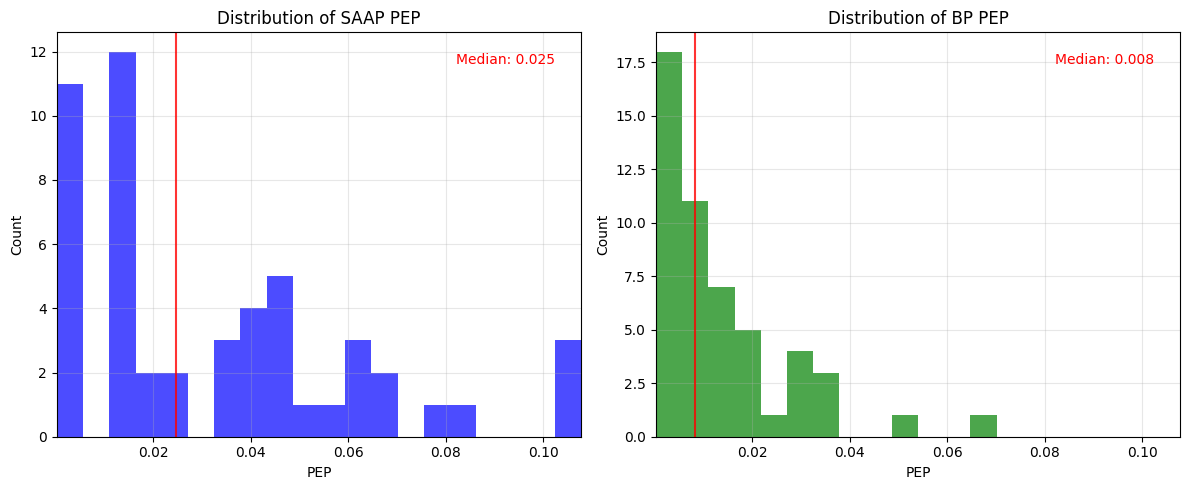

In [26]:
# Create histograms for PEP distributions
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Extract PEP values from results
saap_peps = [r['SAAP PEP'] for r in results if not np.isnan(r['SAAP PEP'])]
bp_peps = [r['BP PEP'] for r in results if not np.isnan(r['BP PEP'])]

# Find the overall min and max for consistent x-axis
x_min = min(min(saap_peps), min(bp_peps))
x_max = max(max(saap_peps), max(bp_peps))

# Calculate medians
saap_median = np.median(saap_peps)
bp_median = np.median(bp_peps)

# Plot SAAP PEP histogram
ax1.hist(saap_peps, bins=20, alpha=0.7, color='blue', range=(x_min, x_max))
ax1.axvline(saap_median, color='red', alpha=0.8)
ax1.text(x_max * 0.95, ax1.get_ylim()[1] * 0.95, f'Median: {saap_median:.3f}', 
         color='red', ha='right', va='top')
ax1.set_title('Distribution of SAAP PEP')
ax1.set_xlabel('PEP')
ax1.set_ylabel('Count')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(x_min, x_max)

# Plot BP PEP histogram
ax2.hist(bp_peps, bins=20, alpha=0.7, color='green', range=(x_min, x_max))
ax2.axvline(bp_median, color='red',  alpha=0.8)
ax2.text(x_max * 0.95, ax2.get_ylim()[1] * 0.95, f'Median: {bp_median:.3f}', 
         color='red', ha='right', va='top')
ax2.set_title('Distribution of BP PEP')
ax2.set_xlabel('PEP')
ax2.set_ylabel('Count')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(x_min, x_max)

plt.tight_layout()
plt.show()